In [278]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

In [279]:
#Reading the data
df =  pd.read_csv("./data/uber.csv")


### Data cleaning

In [280]:
# Dropping columns which has no significance
df = df.drop(columns=['Unnamed: 0', 'key'])
# Check for null values-- Only 2 null values, so dropped them
df.isnull().sum()
df = df.dropna()

In [281]:
duplicate_rows = df[df.duplicated()]

# Step 2: Count the number of duplicate rows
num_duplicates = duplicate_rows.shape[0]

# Display the number of duplicate rows
print("Number of duplicate rows:", num_duplicates)

# Display the duplicate rows
if num_duplicates > 0:
    print("Duplicate rows:")
    print(duplicate_rows)

Number of duplicate rows: 0


In [282]:
# Extracting date, month, day, year from pickup datetime column 
df.loc[:, 'pickup_datetime'] = pd.to_datetime(df.loc[:, 'pickup_datetime'])
df.loc[:, 'Year'] = df.loc[:, 'pickup_datetime'].apply(lambda time: time.year)
df.loc[:, 'Month'] = df.loc[:, 'pickup_datetime'].apply(lambda time: time.month)
df.loc[:,'Day of Week'] = df['pickup_datetime'].apply(lambda time: time.dayofweek)
df.loc[:,'Day of Week_num'] = df['pickup_datetime'].apply(lambda time: time.dayofweek)
df.loc[:,'Hour'] = df['pickup_datetime'].apply(lambda time: time.hour)

day_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df.loc[:,'Day of Week'] = df['Day of Week'].map(day_map)
df['counter'] = 1



/var/folders/f6/3j2ss2s17kng3g2xrm_hz4sm0000gn/T/ipykernel_7594/2334392040.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Thu' 'Fri' 'Mon' ... 'Mon' 'Wed' 'Sat']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,'Day of Week'] = df['Day of Week'].map(day_map)


In [283]:
# Checking all the dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199999 non-null  float64
 1   pickup_datetime    199999 non-null  object 
 2   pickup_longitude   199999 non-null  float64
 3   pickup_latitude    199999 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    199999 non-null  int64  
 7   Year               199999 non-null  int64  
 8   Month              199999 non-null  int64  
 9   Day of Week        199999 non-null  object 
 10  Day of Week_num    199999 non-null  int64  
 11  Hour               199999 non-null  int64  
 12  counter            199999 non-null  int64  
dtypes: float64(5), int64(6), object(2)
memory usage: 21.4+ MB


In [284]:
df.nunique().sort_values()

counter                   1
Year                      7
Day of Week               7
Day of Week_num           7
passenger_count           8
Month                    12
Hour                     24
fare_amount            1244
pickup_longitude      71065
dropoff_longitude     76894
pickup_latitude       83835
dropoff_latitude      90585
pickup_datetime      196628
dtype: int64

Depending on the types, the dataset has categorical columns which are Month, hour, day of week.

In [285]:
# Calculate distance from the lattidue and longitude(pick up and drop off)
def haversine(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude):
    # Convert decimal degrees to radians
    pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude = map(np.radians, [pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude])
    
    # Haversine formula
    dlon = dropoff_longitude - pickup_longitude 
    dlat = dropoff_latitude - pickup_latitude 
    a = np.sin(dlat/2)**2 + np.cos(pickup_latitude) * np.cos(dropoff_latitude) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

df['trip_distance_km'] = df.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'],row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

In [286]:
df1= df.describe()
df1
# df1.to_csv('processed_data.csv', index=False)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day of Week_num,Hour,counter,trip_distance_km
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.0,199999.000000
mean,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543,2011.742434,6.281791,3.048435,13.491387,1.0,20.855350
std,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995,1.856400,3.438933,1.946946,6.515505,0.0,382.964642
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,2009.000000,1.000000,0.000000,0.000000,1.0,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000,2010.000000,3.000000,1.000000,9.000000,1.0,1.215222
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000,2012.000000,6.000000,3.000000,14.000000,1.0,2.120992
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000,2013.000000,9.000000,5.000000,19.000000,1.0,3.875169
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000,2015.000000,12.000000,6.000000,23.000000,1.0,16409.239135


### Data overview of Categorical variables

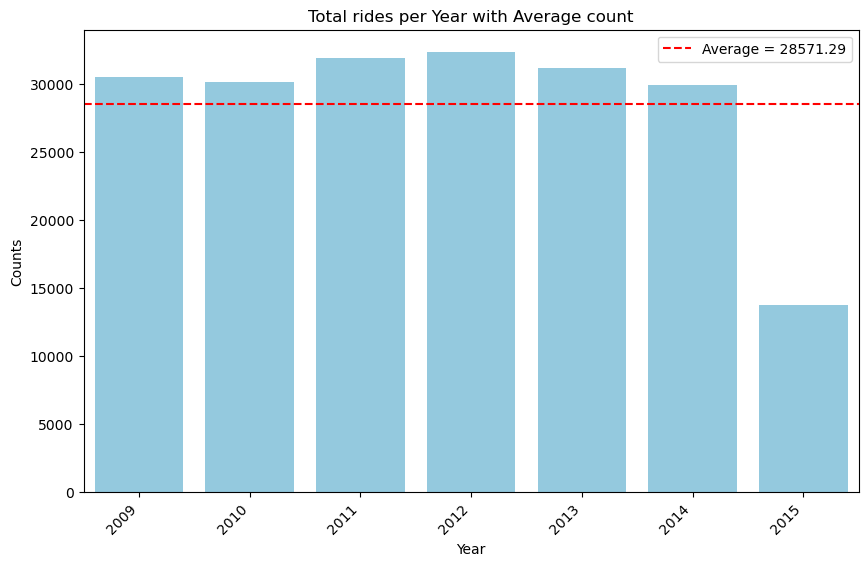

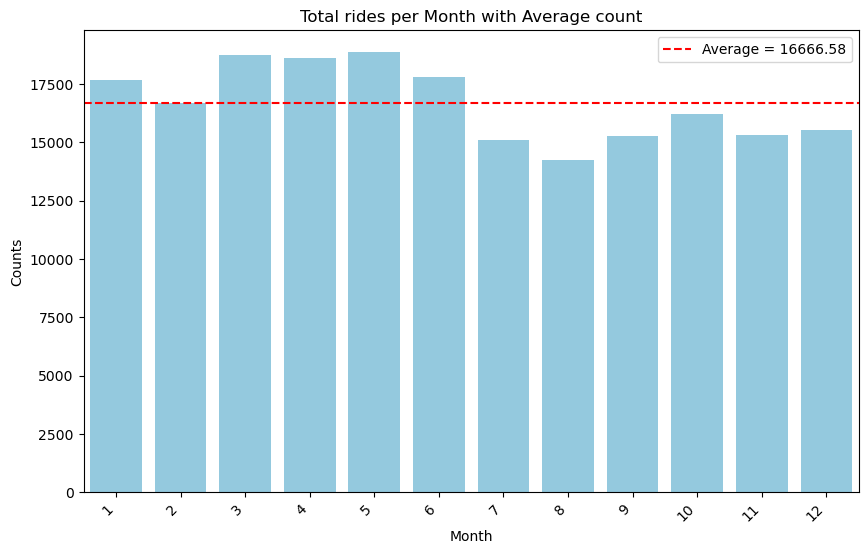

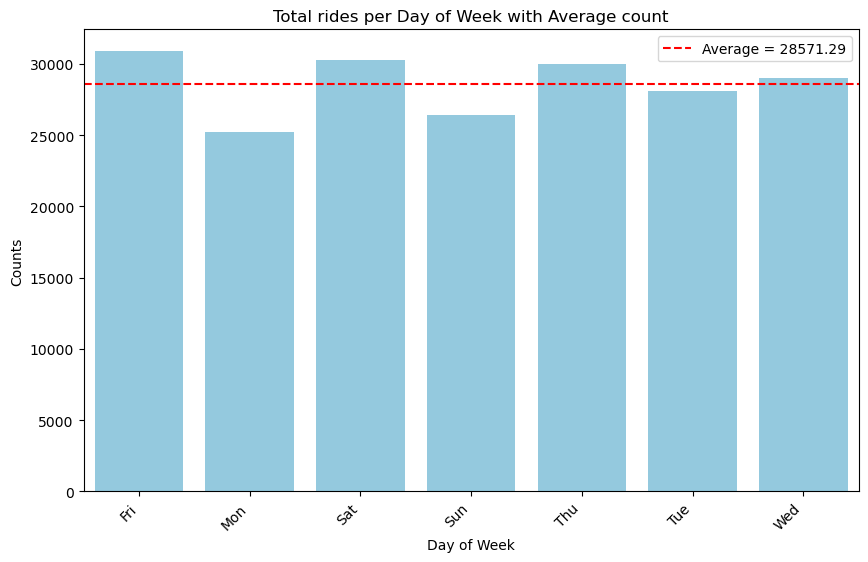

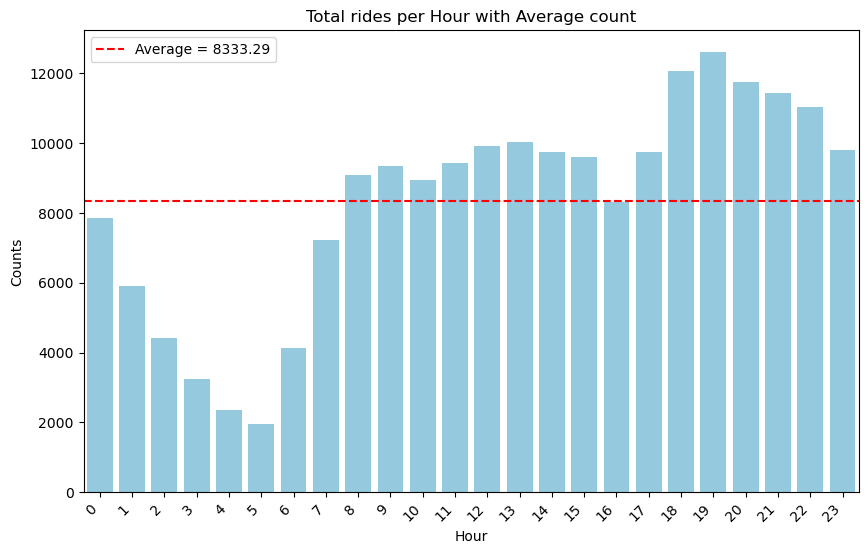

In [287]:
def plot_value_counts_with_avg(df, column_name):

    # Calculate value counts for the specified column
    value_counts = df[column_name].value_counts().sort_index()

    # Calculate the average count
    average_count = value_counts.mean()

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values, color='skyblue')

    # Add a horizontal line for the average value count
    plt.axhline(average_count, color='red', linestyle='--', label=f'Average = {average_count:.2f}')

    # Add title and labels
    plt.title(f'Total rides per {column_name} with Average count')
    plt.ylabel('Counts')
    plt.xlabel(column_name)

    # Rotate x labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()


# Plot value counts for 'Year'
plot_value_counts_with_avg(df, 'Year')

# Plot value counts for 'Month'
plot_value_counts_with_avg(df, 'Month')

# Plot value counts for 'Day'
plot_value_counts_with_avg(df, 'Day of Week')

# Plot value counts for 'Hour'
plot_value_counts_with_avg(df, 'Hour')

### Data overview of continuous numerical variable

In [288]:
df_numerical = df.select_dtypes(include=['number'])

threshold = 25  # For unique values >24 what is considered "continuous"
continuous_columns = [col for col in df_numerical.columns if df_numerical[col].nunique() > threshold]

df_continuous = df_numerical[continuous_columns]
df_continuous


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1.683323
1,7.7,-73.994355,40.728225,-73.994710,40.750325,2.457590
2,12.9,-74.005043,40.740770,-73.962565,40.772647,5.036377
3,5.3,-73.976124,40.790844,-73.965316,40.803349,1.661683
4,16.0,-73.925023,40.744085,-73.973082,40.761247,4.475450
...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,0.112210
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1.875050
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,12.850319
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,3.539715


<Figure size 1200x600 with 0 Axes>

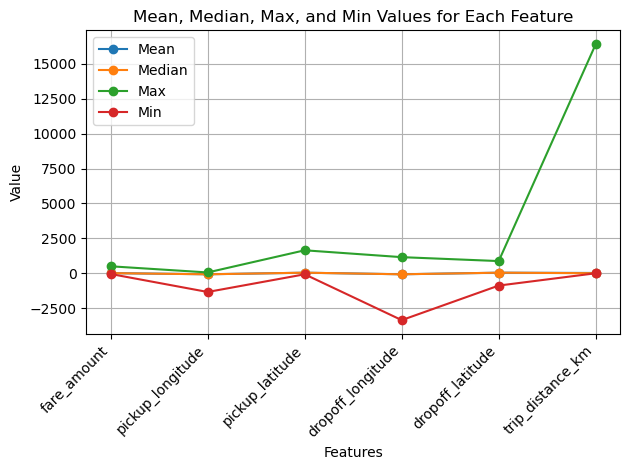

In [289]:

mean_values = df_continuous.mean()
median_values = df_continuous.median()
max_values = df_continuous.max()
min_values = df_continuous.min()

# Step 2: Combine these into a DataFrame for easier plotting
stats_df = pd.DataFrame({
    'Mean': mean_values,
    'Median': median_values,
    'Max': max_values,
    'Min': min_values
})

# Step 3: Create the line plot
plt.figure(figsize=(12, 6))
stats_df.plot(kind='line', marker='o')

# Add title and labels
plt.title('Mean, Median, Max, and Min Values for Each Feature')
plt.ylabel('Value')
plt.xlabel('Features')

# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

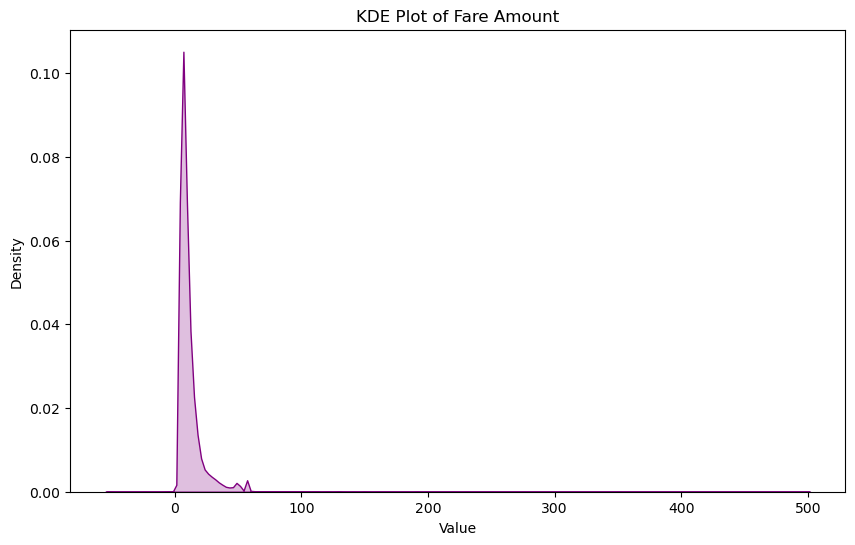

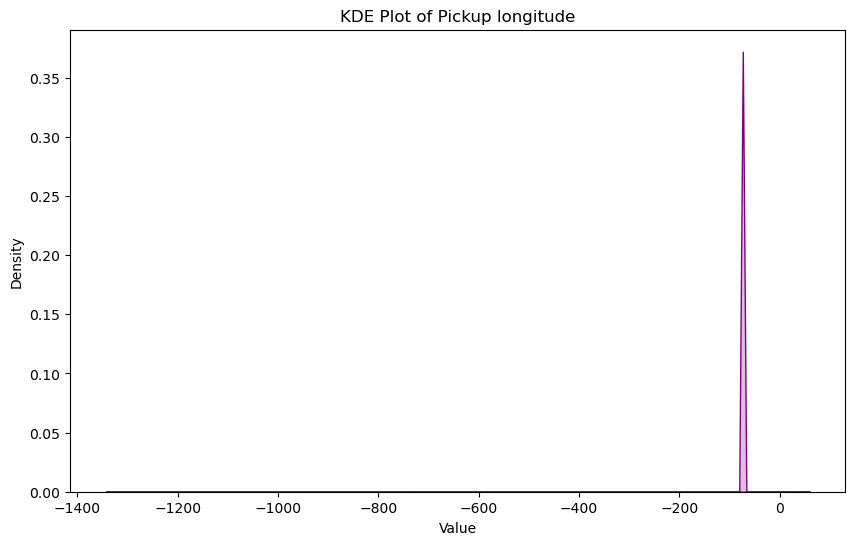

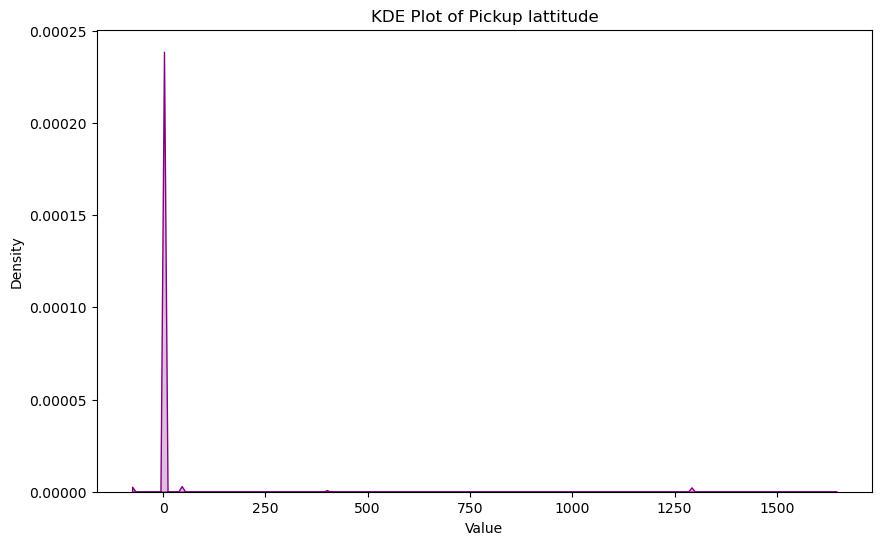

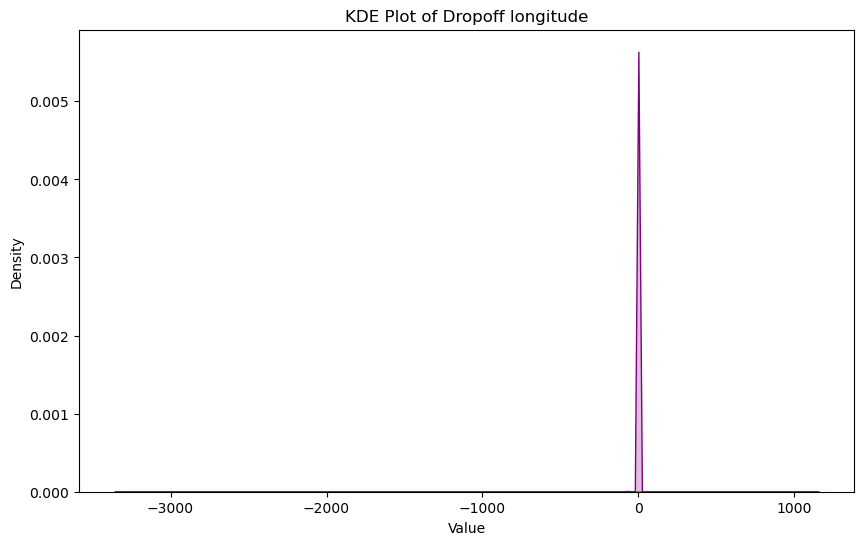

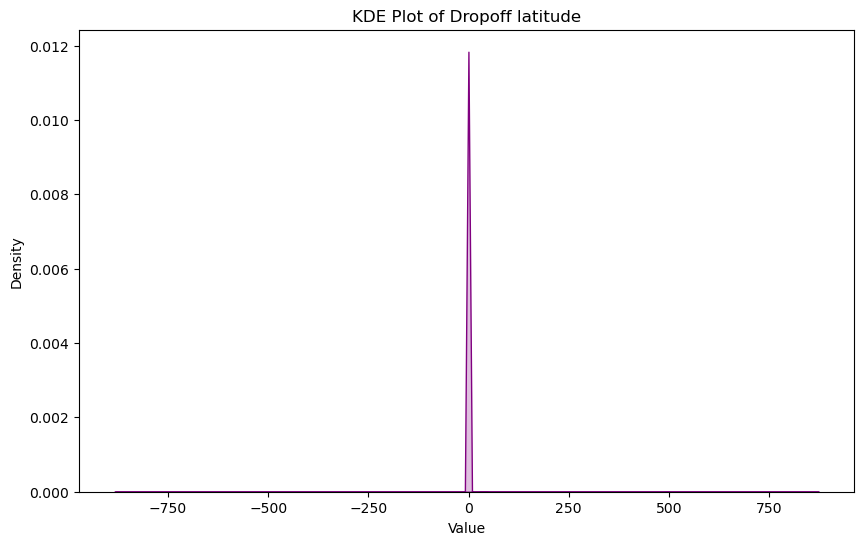

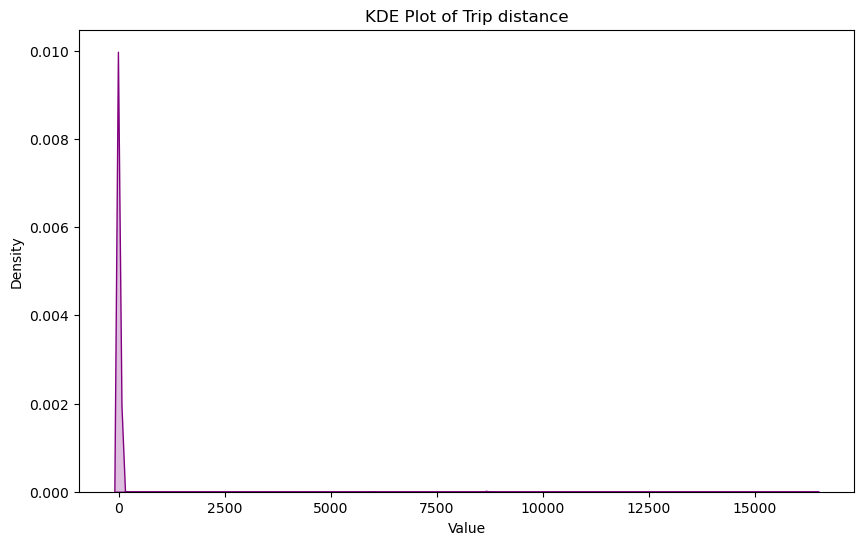

In [290]:
def plot_kde(df_continuous, column_name, plot_title='KDE Plot of Column'):
   
    # Check if the column exists in the DataFrame
    if column_name not in df_continuous.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    # Generate the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df[column_name], fill=True, color='purple')

    # Add title and labels
    plt.title(plot_title)
    plt.xlabel('Value')
    plt.ylabel('Density')

    # Display the plot
    plt.show()

# Example usage:
# Assuming df_numeric is your DataFrame with numeric variables
# and you want to plot the KDE plot for a specific column
plot_kde(df_continuous, 'fare_amount', plot_title='KDE Plot of Fare Amount')
plot_kde(df_continuous, 'pickup_longitude', plot_title='KDE Plot of Pickup longitude')
plot_kde(df_continuous, 'pickup_latitude', plot_title='KDE Plot of Pickup lattitude')
plot_kde(df_continuous, 'dropoff_longitude', plot_title='KDE Plot of Dropoff longitude')
plot_kde(df_continuous, 'dropoff_latitude', plot_title='KDE Plot of Dropoff latitude')
plot_kde(df_continuous, 'trip_distance_km', plot_title='KDE Plot of Trip distance')


### Descriptive statistics

Sum, Count: Total fare collected, total distance covered, and the number of trips.--using tableau dashboard -->

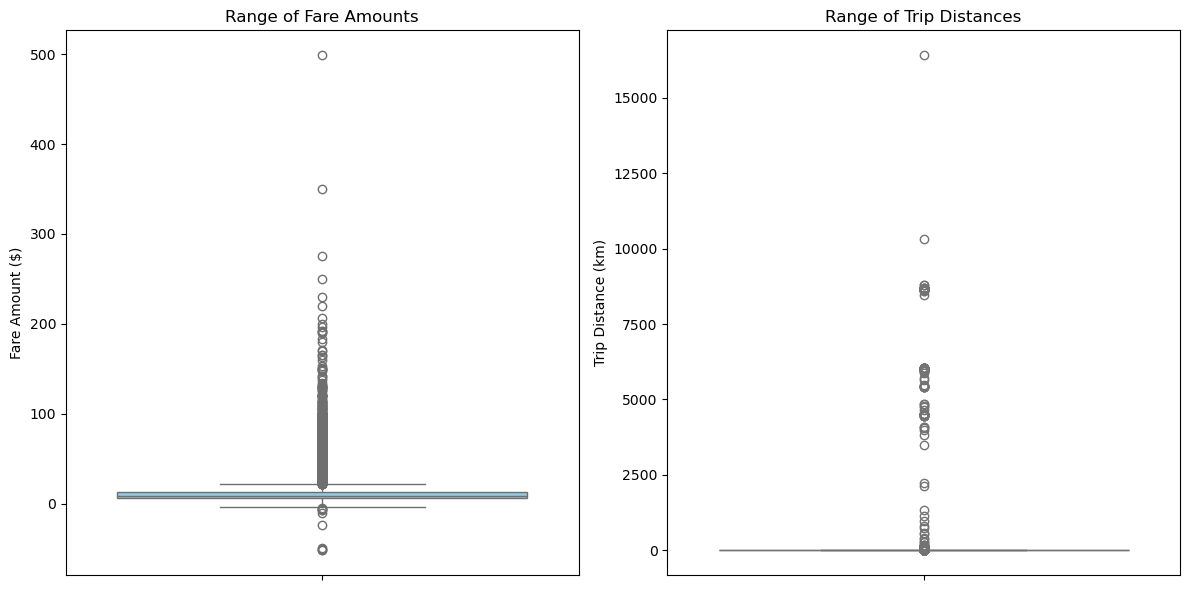

In [291]:
plt.figure(figsize=(12, 6))

# Create a subplot for fare amount
plt.subplot(1, 2, 1)
sns.boxplot(y=df['fare_amount'], color='skyblue')
plt.title('Range of Fare Amounts')
plt.ylabel('Fare Amount ($)')
plt.xlabel('')

# Create a subplot for trip distance
plt.subplot(1, 2, 2)
sns.boxplot(y=df['trip_distance_km'], color='lightgreen')
plt.title('Range of Trip Distances')
plt.ylabel('Trip Distance (km)')
plt.xlabel('')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

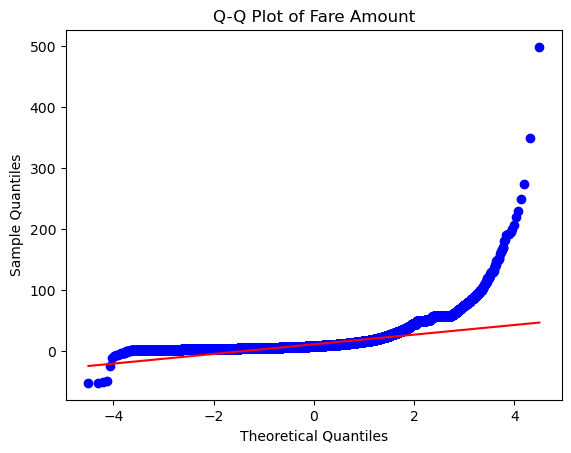

In [292]:
stats.probplot(df['fare_amount'], dist="norm", plot=plt)

# Add title and labels
plt.title('Q-Q Plot of Fare Amount')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Show plot
plt.show()

In [293]:
negative_fare = df[df['fare_amount'] <0]
negative_fare.count()


fare_amount          17
pickup_datetime      17
pickup_longitude     17
pickup_latitude      17
dropoff_longitude    17
dropoff_latitude     17
passenger_count      17
Year                 17
Month                17
Day of Week          17
Day of Week_num      17
Hour                 17
counter              17
trip_distance_km     17
dtype: int64

### Removing outlier
If a rider has a promotional code, discount, or credit that exceeds the total fare, the resulting fare could technically be negative.If a rider is charged a fare and later a refund is issued for some reason (e.g., driver canceled, service issues, etc.), the adjustment might be processed in a way that creates a negative fare. Datta entry issue. But as these may lead to miscalculation we are removing the outliers. Count- 7

In [294]:
df=df[df['fare_amount'] > 0]
df['fare_amount'].describe()
#The trip might have started, but it was canceled shortly after, either by the driver or the rider. In this case, the trip would be logged in the system, but no significant distance would be covered, resulting in a recorded distance of 0.GPS devices sometimes fail to accurately record the trip's start and end locations due to signal loss, poor connectivity, or device malfunctions. No show or immediate drop off.

count    199977.000000
mean         11.362586
std           9.897063
min           0.010000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

## Anomalies
### Check for zero distance trips which may require later.

In [295]:
zero_distance_trips = df[df['trip_distance_km'] == 0]
df['passenger_count'].unique()
zero_passenger_count = df.loc[df['passenger_count'] == 0]
zero_passenger_count

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day of Week,Day of Week_num,Hour,counter,trip_distance_km
333,10.1,2011-08-05 07:03:08+00:00,-74.013900,40.707800,-73.992300,40.749300,0,2011,8,Fri,4,7,1,4.960570
908,11.7,2011-09-06 12:25:19+00:00,-73.981000,40.764600,-73.962900,40.778400,0,2011,9,Tue,1,12,1,2.162835
926,3.3,2012-03-26 18:11:24+00:00,-73.979978,40.765821,-73.983894,40.766873,0,2012,3,Mon,0,18,1,0.349924
2000,15.7,2012-04-20 15:07:57+00:00,-73.975285,40.750138,-73.974729,40.783151,0,2012,4,Fri,4,15,1,3.671177
3011,6.1,2012-01-07 19:19:08+00:00,-73.977900,40.789100,-73.983700,40.773600,0,2012,1,Sat,5,19,1,1.791370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196797,3.3,2011-01-17 15:52:26+00:00,-74.000760,40.757637,-74.004852,40.751947,0,2011,1,Mon,0,15,1,0.720492
197103,7.3,2011-12-10 15:33:12+00:00,0.000000,0.000000,0.000000,0.000000,0,2011,12,Sat,5,15,1,0.000000
198872,5.7,2011-09-20 19:55:05+00:00,-73.980300,40.742800,-73.967900,40.755600,0,2011,9,Tue,1,19,1,1.765465
198902,12.1,2011-08-22 21:10:56+00:00,-73.996700,40.737200,-74.008500,40.704000,0,2011,8,Mon,0,21,1,3.823264


### 2. Temporal Analysis:

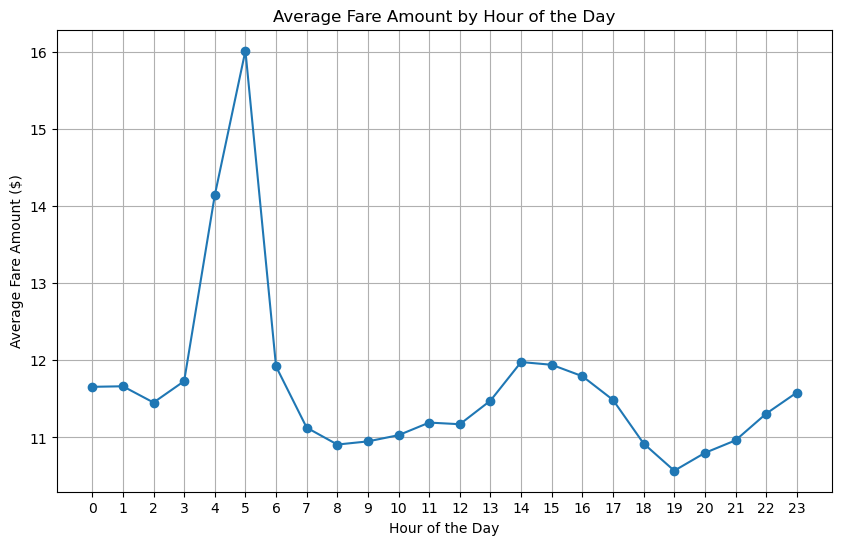

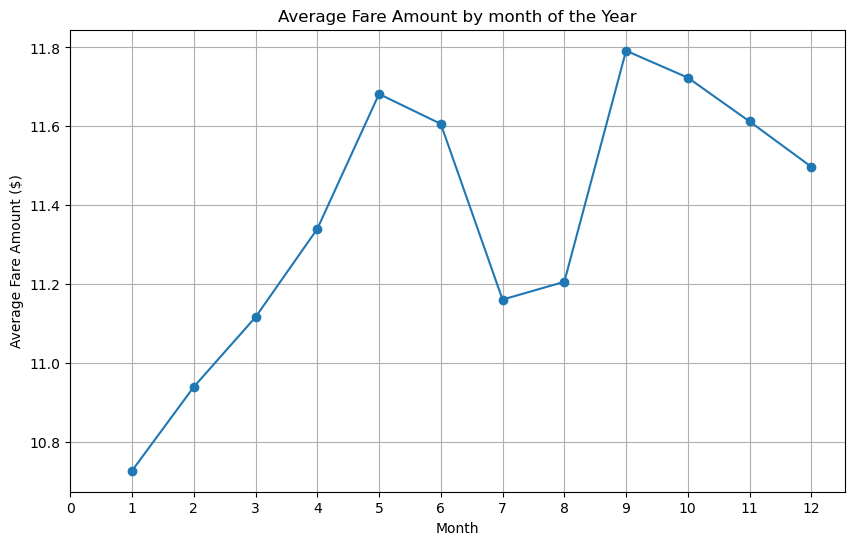

In [296]:
average_fare_by_hour = df.groupby('Hour')['fare_amount'].mean()
average_fare_by_month = df.groupby('Month')['fare_amount'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_fare_by_hour.index, average_fare_by_hour.values, marker='o')
plt.title('Average Fare Amount by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Fare Amount ($)')
plt.xticks(range(0, 24))  # Ensure all hours are labeled
plt.grid(True)
plt.figure(figsize=(10, 6))
plt.plot(average_fare_by_month.index, average_fare_by_month.values, marker='o')
plt.title('Average Fare Amount by month of the Year')
plt.xlabel('Month')
plt.ylabel('Average Fare Amount ($)')
plt.xticks(range(0, 13))  # Ensure all hours are labeled
plt.grid(True)
plt.show()

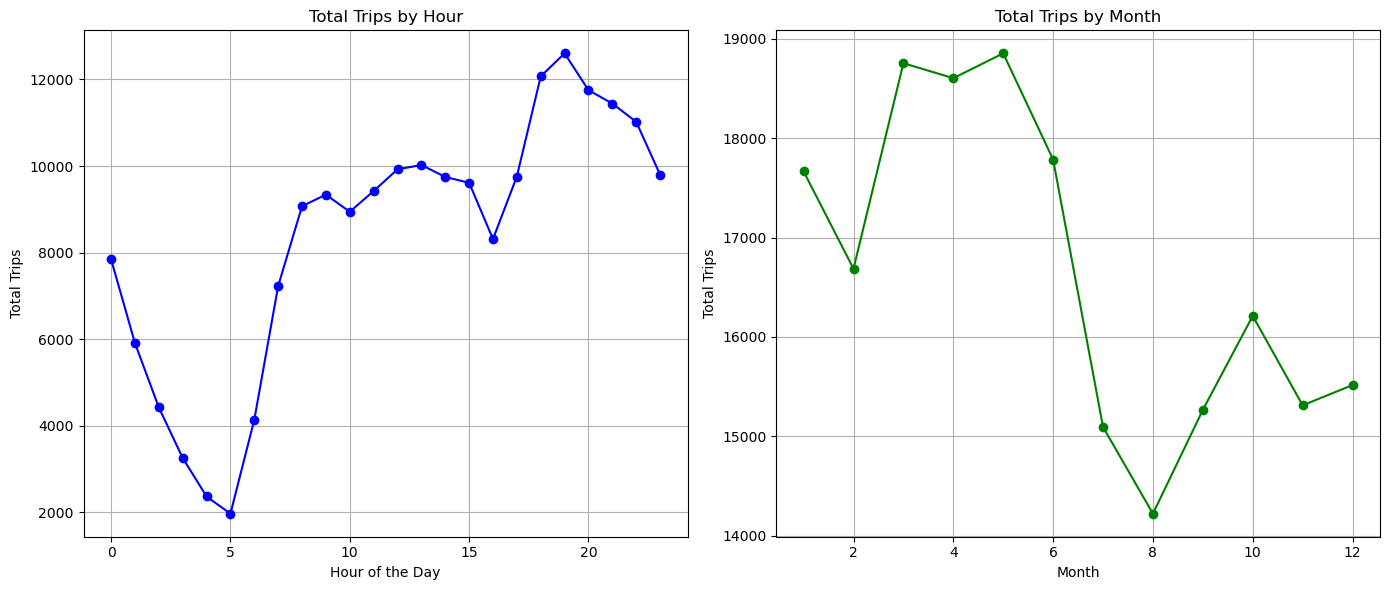

In [297]:
rush_hour = df.groupby('Hour')['counter'].sum()
rush_month = df.groupby('Month')['counter'].sum()

plt.figure(figsize=(14, 6))

# Line plot for rush_hour
plt.subplot(1, 2, 1)
plt.plot(rush_hour.index, rush_hour.values, marker='o', color='blue')
plt.title('Total Trips by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Trips')
plt.grid(True)

# Line plot for rush_month
plt.subplot(1, 2, 2)
plt.plot(rush_month.index, rush_month.values, marker='o', color='green')
plt.title('Total Trips by Month')
plt.xlabel('Month')
plt.ylabel('Total Trips')
plt.grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Passenger Behavior Analysis:

In [298]:
df['passenger_count'].unique()
filtered_df = df.loc[df['passenger_count'] == 0]
filtered_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day of Week,Day of Week_num,Hour,counter,trip_distance_km
333,10.1,2011-08-05 07:03:08+00:00,-74.013900,40.707800,-73.992300,40.749300,0,2011,8,Fri,4,7,1,4.960570
908,11.7,2011-09-06 12:25:19+00:00,-73.981000,40.764600,-73.962900,40.778400,0,2011,9,Tue,1,12,1,2.162835
926,3.3,2012-03-26 18:11:24+00:00,-73.979978,40.765821,-73.983894,40.766873,0,2012,3,Mon,0,18,1,0.349924
2000,15.7,2012-04-20 15:07:57+00:00,-73.975285,40.750138,-73.974729,40.783151,0,2012,4,Fri,4,15,1,3.671177
3011,6.1,2012-01-07 19:19:08+00:00,-73.977900,40.789100,-73.983700,40.773600,0,2012,1,Sat,5,19,1,1.791370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196797,3.3,2011-01-17 15:52:26+00:00,-74.000760,40.757637,-74.004852,40.751947,0,2011,1,Mon,0,15,1,0.720492
197103,7.3,2011-12-10 15:33:12+00:00,0.000000,0.000000,0.000000,0.000000,0,2011,12,Sat,5,15,1,0.000000
198872,5.7,2011-09-20 19:55:05+00:00,-73.980300,40.742800,-73.967900,40.755600,0,2011,9,Tue,1,19,1,1.765465
198902,12.1,2011-08-22 21:10:56+00:00,-73.996700,40.737200,-74.008500,40.704000,0,2011,8,Mon,0,21,1,3.823264


In [299]:
rows_to_drop = df.loc[df['passenger_count'] == 208].index

# Step 2: Drop these rows from the DataFrame
df = df.drop(rows_to_drop)

# Optional: Reset the index if needed
df = df.reset_index(drop=True)
df['passenger_count'].unique()

array([1, 3, 5, 2, 4, 6, 0])

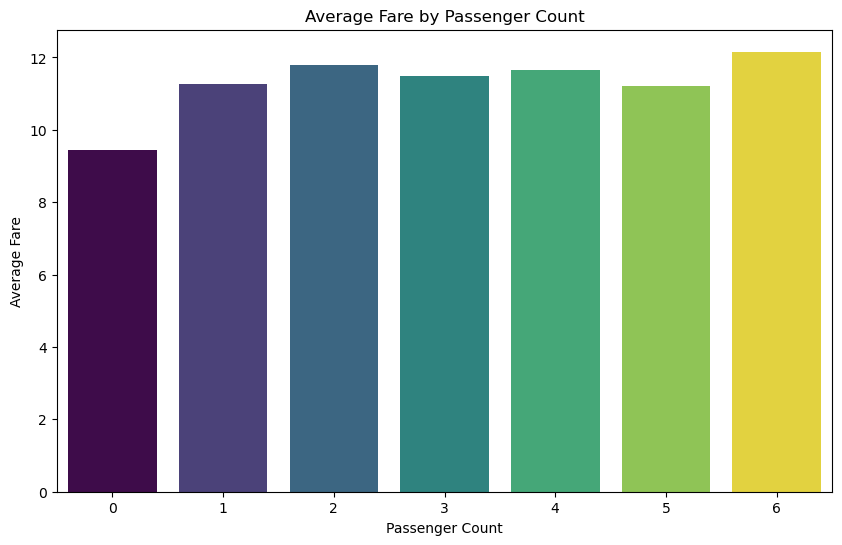

In [300]:
def plot_avg_fare_by_passenger_count(df, fare_amount, passenger_count):

    avg_fare_by_passenger = df.groupby(passenger_count)[fare_amount].mean().reset_index()

    # Step 2: Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=passenger_count, y=fare_amount,hue=passenger_count,  data=avg_fare_by_passenger, palette='viridis',legend=False)

    # Step 3: Add title and labels
    plt.title('Average Fare by Passenger Count')
    plt.xlabel('Passenger Count')
    plt.ylabel('Average Fare')

    # Display the plot
    plt.show()

# Example usage:
# Assuming df is your DataFrame containing 'fare_amount' and 'passenger_count'
plot_avg_fare_by_passenger_count(df, 'fare_amount', 'passenger_count')

## Cleaning

In [301]:
def remove_outliers(df, columns):
    """
    Removes outliers from the specified columns in the DataFrame using the IQR method.
    
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    columns (list): A list of column names to check for outliers.
    
    Returns:
    DataFrame: A DataFrame with outliers removed.
    """
    # For each column, calculate the IQR and filter out outliers
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df

# Example usage:
# Assuming df is your DataFrame and you want to remove outliers from the 'fare_amount' and 'trip_distance_km' columns
columns_to_check = ['fare_amount', 'trip_distance_km']
df_clean = remove_outliers(df, columns_to_check)

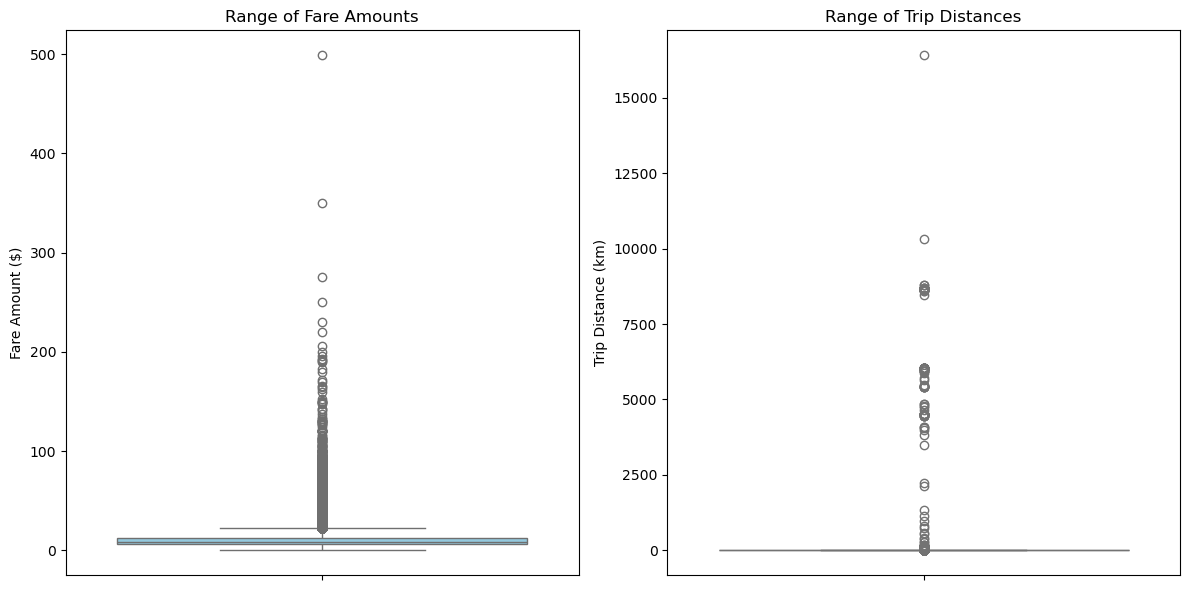

In [302]:
plt.figure(figsize=(12, 6))

# Create a subplot for fare amount
plt.subplot(1, 2, 1)
sns.boxplot(y=df['fare_amount'], color='skyblue')
plt.title('Range of Fare Amounts')
plt.ylabel('Fare Amount ($)')
plt.xlabel('')

# Create a subplot for trip distance
plt.subplot(1, 2, 2)
sns.boxplot(y=df['trip_distance_km'], color='lightgreen')
plt.title('Range of Trip Distances')
plt.ylabel('Trip Distance (km)')
plt.xlabel('')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

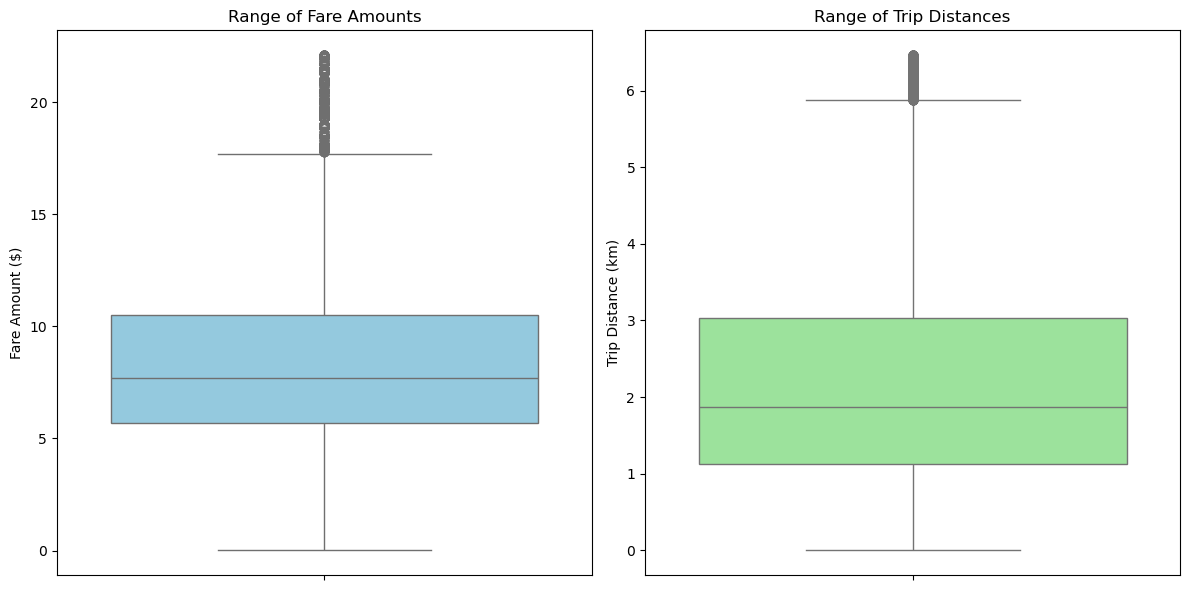

In [303]:
plt.figure(figsize=(12, 6))

# Create a subplot for fare amount
plt.subplot(1, 2, 1)
sns.boxplot(y=df_clean['fare_amount'], color='skyblue')
plt.title('Range of Fare Amounts')
plt.ylabel('Fare Amount ($)')
plt.xlabel('')

# Create a subplot for trip distance
plt.subplot(1, 2, 2)
sns.boxplot(y=df_clean['trip_distance_km'], color='lightgreen')
plt.title('Range of Trip Distances')
plt.ylabel('Trip Distance (km)')
plt.xlabel('')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [304]:
correlation_matrix = df_numerical.corr()

<Axes: >

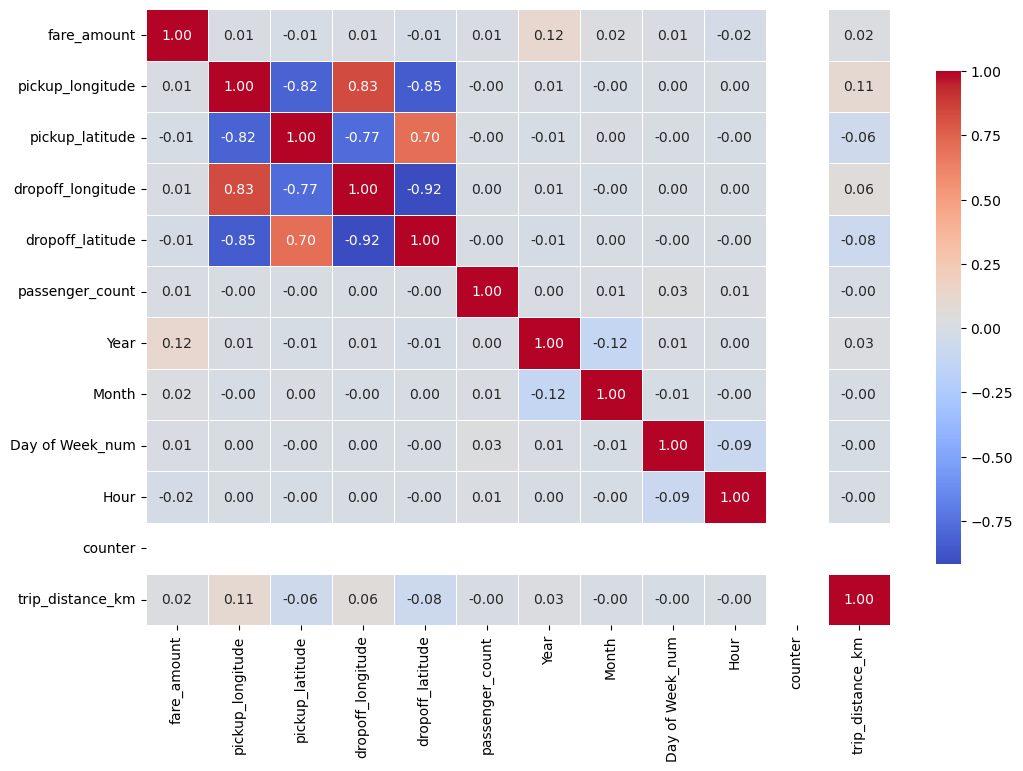

In [305]:
plt.figure(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})

### 1. Checking for anomalies

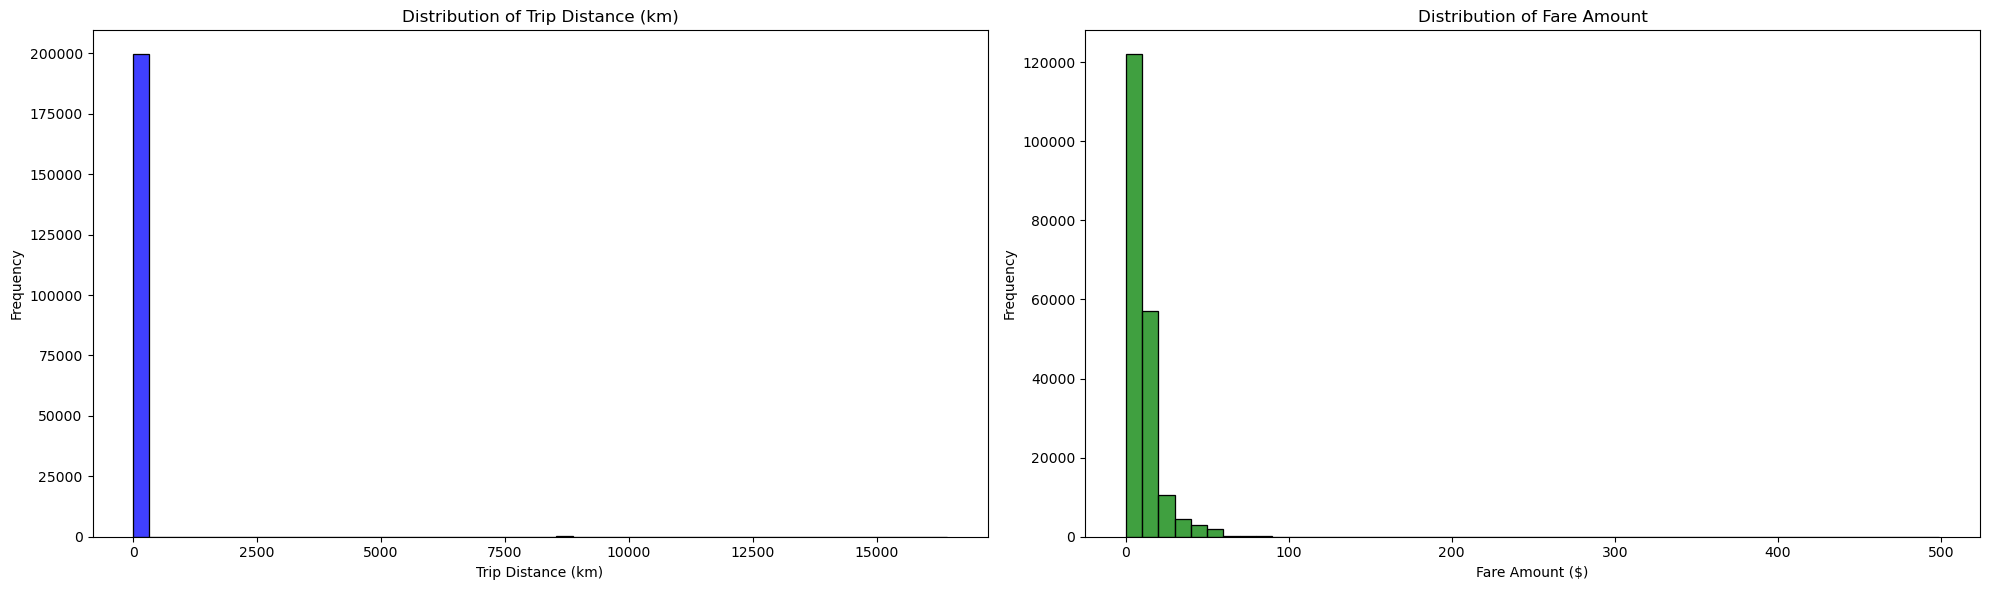

In [306]:
plt.figure(figsize=(20, 6))

# Histogram for trip_distance_km
plt.subplot(1, 2, 1)
sns.histplot(df['trip_distance_km'], bins=50, kde=False, color='blue')
plt.title('Distribution of Trip Distance (km)')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Frequency')

# Histogram for fare_amount
plt.subplot(1, 2, 2)
sns.histplot(df['fare_amount'], bins=50, kde=False, color='green')
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### 2. Feature engineering

In [307]:
df_clean['Month_sin'] = np.sin(2 * np.pi * df_clean['Month'] / 12)
df_clean['Month_cos'] = np.cos(2 * np.pi * df_clean['Month'] / 12)

df_clean['Hour_sin'] = np.sin(2 * np.pi * df_clean['Hour'] / 24)
df_clean['Hour_cos'] = np.cos(2 * np.pi * df_clean['Hour'] / 24)

df_clean['day_sin'] = np.sin(2 * np.pi * df_clean['Day of Week_num'] / 24)
df_clean['day_cos'] = np.cos(2 * np.pi * df_clean['Day of Week_num'] / 24)

In [308]:
#Get dummies incase required
# df_encoded = pd.get_dummies(df_clean, columns=['Month', 'Day of Week_num', 'Hour'], prefix=['Month', 'Day', 'Hour'], drop_first=False)

# df_encoded = df_encoded.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# # OR using select_dtypes to target only boolean columns
# df_encoded[df_encoded.select_dtypes(include=['bool']).columns] = df_encoded.select_dtypes(include=['bool']).astype(int)
# df_encoded


<Axes: >

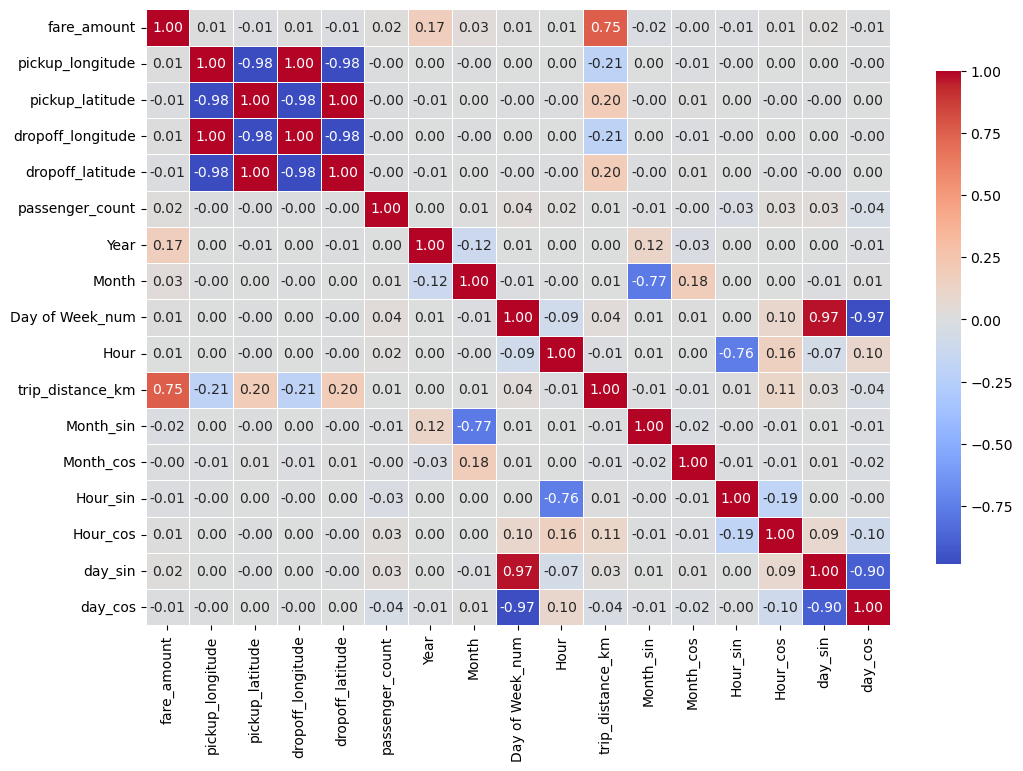

In [320]:
df_numerical = df_clean.select_dtypes(include=['number'])
df_numerical = df_numerical.drop(columns=['counter'])

correlation_matrix = df_numerical.corr()
plt.figure(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})

### 3. Data preparation

In [310]:
target = df_clean['fare_amount']
features = df_clean.drop(columns=['fare_amount', 'pickup_datetime','counter','Day of Week'])

In [311]:
# split data into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

In [312]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [313]:
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# # Step 4: Feature Scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Step 5: Model Selection and Training
# # Using RandomForestRegressor as an example
# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train_scaled, y_train)

# # Step 6: Model Evaluation
# y_pred = model.predict(X_test_scaled)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f'Mean Squared Error: {mse}')
# print(f'R-squared: {r2}')

# # Step 7: Making Predictions
# # Example: Predict the fare amount for the first few rows of the test set
# predicted_fares = model.predict(X_test_scaled[:5])
# print(f'Predicted Fares: {predicted_fares}')
# print(f'Actual Fares: {y_test[:5].values}')

In [314]:
# from sklearn.decomposition import PCA

# pca = PCA().fit(X_train)

# fig, ax = plt.subplots(figsize=(8,6))
# x_values = range(1, pca.n_components_+1)
# ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
# ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
# plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
# ax.set_title('Explained variance of components')
# ax.set_xlabel('Principal Component')
# ax.set_ylabel('Explained Variance')
# plt.legend()
# plt.grid()
# plt.show()

In [315]:
# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.svm import SVR

# # Define model types suitable for regression tasks
# models_dict = {
#     'Random Forest n=100 depth=10': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)}

# # Train and evaluate model types
# df_result = model_testing(X_train, X_test, y_train, y_test, models_dict)

# print(df_result)

### 4.Perform scaling

In [316]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # If you want to scale y_train and y_test (which is common in regression tasks)
# y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
# y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# # # Display the scaled data
# # print("X_train_scaled:\n", X_train_scaled[:5])
# # print("X_test_scaled:\n", X_test_scaled[:5])
# # print("y_train_scaled:\n", y_train_scaled[:5])
# # print("y_test_scaled:\n", y_test_scaled[:5])

In [317]:
# from sklearn.neighbors import KNeighborsRegressor
# knn = KNeighborsRegressor(n_neighbors=10)
# knn.fit(X_train, y_train)
# knn.score(X_test, y_test)

In [318]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score

# # Assuming features and target are your features and target
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# # Initialize and train the Decision Tree Regressor
# dt = DecisionTreeRegressor(max_depth=5)
# dt.fit(X_train, y_train)

# # Predict the target for the test set
# y_pred = dt.predict(X_test)

# # Evaluate the model using Mean Squared Error and R-squared
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f'Mean Squared Error: {mse}')
# print(f'R-squared: {r2}')

In [319]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# mse_standardized = mean_squared_error(y_test, y_pred)
# mae_standardized = mean_absolute_error(y_test, y_pred)
# r2_standardized = r2_score(y_test, y_pred)
# r2_standardized
# mae_standardized
# mae_standardized